## Part A Question 3

In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
shap.initjs()


import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from sklearn import datasets
from sklearn.model_selection import KFold

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [3]:
df = pd.read_csv('./full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [4]:
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

In [5]:
columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

In [6]:
num_neurons = 128
learning_rate = 0.001
batch_size = 256
no_epochs = 100

**Timing callback for every epoch**

In [7]:
# TimingCallBack class for Q2b

class TimingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

**Callback for early stopping**

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

**Number of folds**

In [9]:
no_folds = 5
cv = KFold(n_splits=no_folds, shuffle=True, random_state=0)

In [10]:
model_neurons_list = ["model_neurons_64", "model_neurons_128", "model_neurons_256"]
num_neurons_list = [64,128,256]

Q3_X, Q3_Y = X_train_scaled, y_train
neurons_idx = 0

In [11]:
model_neurons_list = ["model_neurons_64", "model_neurons_128", "model_neurons_256"]
num_neurons_list = [64,128,256]
model_fold = ["_0", "_1", "_2", "_3" ,"_4"]
optimal_batch_size = 512 #From Question 2

Q3_X, Q3_Y = X_train, y_train
neurons_idx = 0

#### Find the optimal number of hidden neurons for the first hidden layer

In [12]:
Q3_time_taken_dict = {}
Q3_model_acc = {}
Q3_model_train_acc = {}
Q3_model_loss = {}
Q3_history = {}
for model_neurons in model_neurons_list:    
    fold = 0
    val_acc = []
    train_acc = []
    val_loss = []
    time_taken_list = []
    for train_idx, test_idx in cv.split(Q3_X, Q3_Y):
        Q3_cb = TimingCallback()
        Q3_X_train, Q3_y_train  = Q3_X.iloc[train_idx], Q3_Y[train_idx]
        Q3_X_test, Q3_y_test = Q3_X.iloc[test_idx], Q3_Y[test_idx]

        # Rescale the data, so we do the scaling after splitting
        Q3_X_train, Q3_X_test = preprocess_dataset(Q3_X_train, Q3_X_test)

        Q3_model = Sequential([Dense(num_neurons_list[neurons_idx], activation='relu'),
                        Dropout(0.2), Dense(num_neurons, activation ='relu'),
                        Dropout(0.2), Dense(num_neurons, activation='relu'),
                        Dropout(0.2), Dense(1, activation='sigmoid')])
        
        Q3_model.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
        
        Q3_history[model_neurons + model_fold[fold]] = Q3_model.fit(Q3_X_train, Q3_y_train,
                        batch_size = optimal_batch_size,
                        epochs=no_epochs,
                        verbose=1,
                        use_multiprocessing=True,
                        validation_data=(Q3_X_test, Q3_y_test), callbacks=[callback, Q3_cb])
        
        #Time taken of final epoch for each fold 
        time_taken_list.append(Q3_cb.times[-1])
        #print("Time Taken for final epoch " + model_neurons + model_fold[fold] + ": {}".format(Q3_cb.times[-1]))

        #Val accuracy of final epoch of each fold
        val_acc.append(Q3_history[model_neurons + model_fold[fold]].history['val_accuracy'][-1])

        #Train accuracy of final epoch of each fold
        train_acc.append(Q3_history[model_neurons + model_fold[fold]].history['accuracy'][-1])

        #Val loss of final epoch of each fold
        val_loss.append(Q3_history[model_neurons + model_fold[fold]].history['val_loss'][-1])
        
        #print(model_neurons +' fold %d test accuracy %g'%(fold, val_acc[fold]))
        fold += 1
    
    Q3_model_acc[model_neurons] = val_acc
    Q3_model_train_acc[model_neurons] = train_acc
    Q3_time_taken_dict[model_neurons]= time_taken_list
    Q3_model_loss[model_neurons] = val_loss
    print(model_neurons + '* mean accuracy = %g *'% np.mean(val_acc))
    neurons_idx+=1

Epoch 1/100
200/200 [==============================] - 2s 5ms/step - loss: 0.6923 - accuracy: 0.5273 - val_loss: 0.6856 - val_accuracy: 0.5462
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.6864 - accuracy: 0.5446 - val_loss: 0.6829 - val_accuracy: 0.5512
Epoch 3/100
200/200 [==============================] - 1s 4ms/step - loss: 0.6838 - accuracy: 0.5497 - val_loss: 0.6816 - val_accuracy: 0.5573
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.6825 - accuracy: 0.5538 - val_loss: 0.6813 - val_accuracy: 0.5562
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.6807 - accuracy: 0.5573 - val_loss: 0.6793 - val_accuracy: 0.5607
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.6793 - accuracy: 0.5619 - val_loss: 0.6783 - val_accuracy: 0.5658
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.6771 - accuracy: 0.5671 - val_loss: 0.6765 - val_accuracy: 0.5660

## Question 3A

#### Mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons

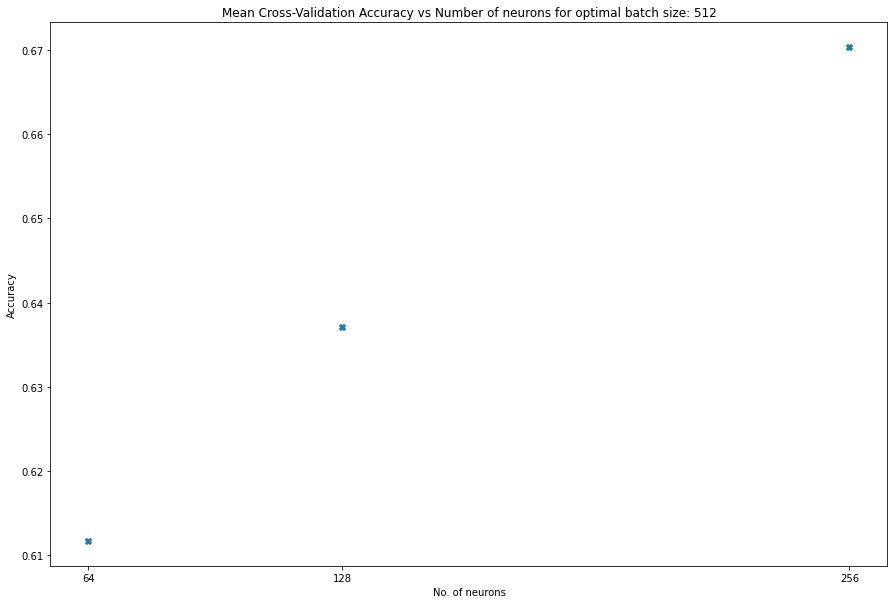

In [13]:
Q3_mean_val_acc = []
for key, value in Q3_model_acc.items():
    Q3_mean_val_acc.append(np.mean(value))

Q3_mean_val_loss = []
for key, value in Q3_model_loss.items():
    Q3_mean_val_loss.append(np.mean(value))

plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(num_neurons_list, Q3_mean_val_acc, marker = 'X')
plt.title('Mean Cross-Validation Accuracy vs Number of neurons for optimal batch size: {}'.format(optimal_batch_size))
plt.ylabel('Accuracy')
plt.xlabel('No. of neurons')
plt.xticks(num_neurons_list)
plt.show()

In [14]:
Q3_mean_time_taken = []
for key, value in Q3_time_taken_dict.items():
    Q3_mean_time_taken.append(np.mean(value))

#### Mean Time Taken on the final epoch for different numbers of hidden-layer neurons

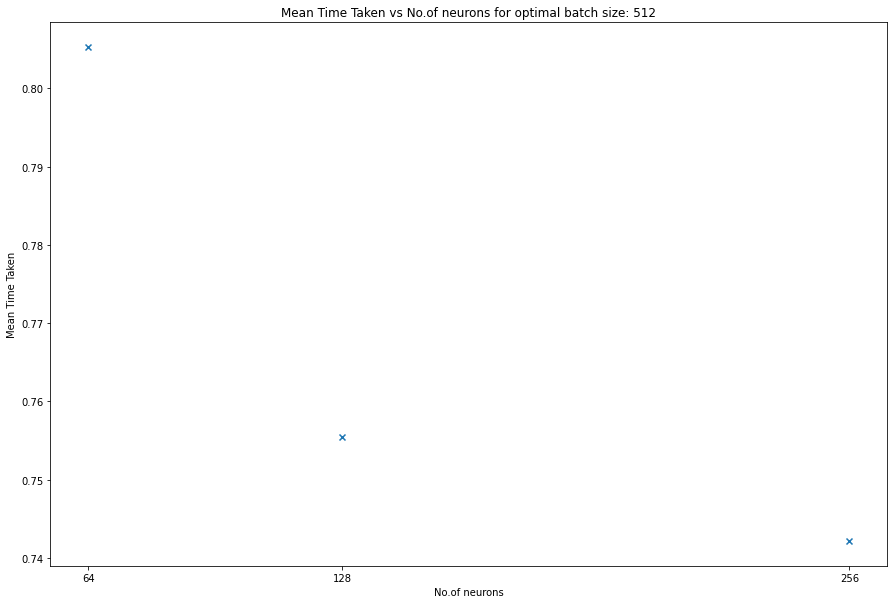

In [15]:
plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(num_neurons_list, Q3_mean_time_taken, marker = 'x')  
plt.title('Mean Time Taken vs No.of neurons for optimal batch size: {}'.format(optimal_batch_size))
plt.ylabel('Mean Time Taken')
plt.xlabel('No.of neurons')
plt.xticks(num_neurons_list)
plt.show()

## Question 3B 
#### Select the optimal number of neurons for the hidden layer

In [16]:
table_df = pd.DataFrame.from_dict(Q3_model_acc,orient='index', columns=["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"])
table_dict = {
              "Mean Val Acc": Q3_mean_val_acc,
              "Mean Val Loss": Q3_mean_val_loss,
              "Mean Time Taken": Q3_mean_time_taken,
              "Model Neurons list": model_neurons_list,
              "Number of neurons": num_neurons_list}
data_df = pd.DataFrame.from_dict(table_dict)

table_df.reset_index(drop=True, inplace=True)
data_df.reset_index(drop=True, inplace=True)    

table_df = pd.concat([table_df, data_df], axis=1)
table_df.set_index('Number of neurons', inplace = True)
table_df

,fold_0,fold_1,fold_2,fold_3,fold_4,Mean Val Acc,Mean Val Loss,Mean Time Taken,Model Neurons list
Number of neurons,,,,,,,,,
64,0.610832,0.615535,0.618225,0.597061,0.616853,0.611701,0.649358,0.805312,model_neurons_64
128,0.652179,0.626548,0.631903,0.636175,0.638918,0.637145,0.625384,0.755477,model_neurons_128
256,0.679299,0.667620,0.664237,0.663884,0.676661,0.670340,0.593939,0.742146,model_neurons_256


In [17]:
optimal_no_neurons = int(table_df['Mean Val Acc'].idxmax())

data = {"Optimal Batch": [optimal_batch_size], "Optimal No.of neurons": [optimal_no_neurons] }

data_df = pd.DataFrame.from_dict(data)
data_df

,Optimal Batch,Optimal No.of neurons
0,512,256


**The selected optimal number of neurons in the hidden layer is 256. The rationale is that it yields the highest mean validation accuracy. It is possible that with the increase in number of neurons in the hidden layer, it allows the train model to be more adaptive and higher capacity to learn.**

**In terms of time taken, when there is a increase number of neurons and the mean time taken for the final epoch does not change significantly nor any obvious relationship was observed thus time taken was not taken into consideration.**

## Question 3C 

#### Train & Test accuracies against training epochs with the optimal number of neurons for different folds

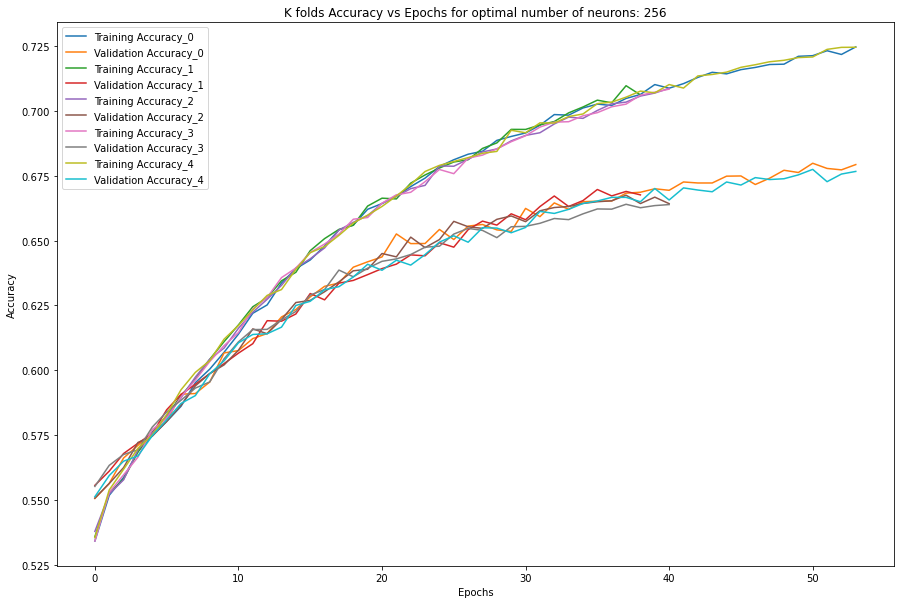

In [18]:
plt_1 = plt.figure(figsize=(15, 10))
fold = 0
optimal_neuron_model = str(table_df.loc[optimal_no_neurons, "Model Neurons list"])

Q3_legend_list = []

while(fold<no_folds):

    plt.plot(Q3_history[optimal_neuron_model + model_fold[fold]].history["accuracy"])
    Q3_legend_list.append("Training Accuracy" + model_fold[fold])

    plt.plot(Q3_history[optimal_neuron_model + model_fold[fold]].history["val_accuracy"])
    Q3_legend_list.append("Validation Accuracy" + model_fold[fold])
    fold+=1

plt.legend(Q3_legend_list)
plt.title('K folds Accuracy vs Epochs for optimal number of neurons: ' + str(optimal_no_neurons))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

#### Training of model with optimal batch size and optimal number of neurons

In [19]:
Q3C_model = Sequential([Dense(optimal_no_neurons, activation='relu'),
                Dropout(0.2), Dense(128, activation ='relu'),
                Dropout(0.2), Dense(128, activation='relu'),
                Dropout(0.2), Dense(1, activation='sigmoid')])

Q3C_model.compile(optimizer='adam', 
            loss='binary_crossentropy',
            metrics=['accuracy'])

Q3C_cb = TimingCallback()

Q3C_history = {}
Q3C_history["Q3C_model"] = Q3C_model.fit(X_train_scaled, y_train,
                batch_size = optimal_batch_size,
                epochs=no_epochs,
                verbose=1,
                use_multiprocessing=True,
                validation_data=(X_test_scaled, y_test), callbacks=[callback,  Q3C_cb])

Epoch 1/100
250/250 [==============================] - 2s 5ms/step - loss: 0.6902 - accuracy: 0.5381 - val_loss: 0.6846 - val_accuracy: 0.5493
Epoch 2/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6830 - accuracy: 0.5559 - val_loss: 0.6809 - val_accuracy: 0.5575
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6790 - accuracy: 0.5640 - val_loss: 0.6799 - val_accuracy: 0.5618
Epoch 4/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6753 - accuracy: 0.5711 - val_loss: 0.6744 - val_accuracy: 0.5709
Epoch 5/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6721 - accuracy: 0.5761 - val_loss: 0.6711 - val_accuracy: 0.5765
Epoch 6/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6676 - accuracy: 0.5843 - val_loss: 0.6683 - val_accuracy: 0.5818
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6626 - accuracy: 0.5936 - val_loss: 0.6619 - val_accuracy: 0.5898

#### Train & Test accuracy against training epochs with the optimal number of neurons 

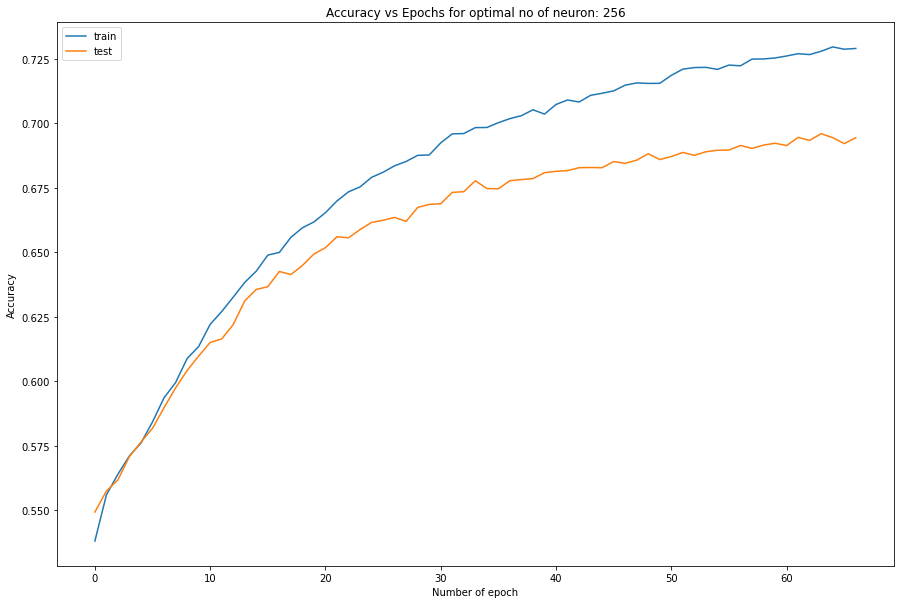

In [20]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(Q3C_history['Q3C_model'].history['accuracy'])
plt.plot(Q3C_history['Q3C_model'].history['val_accuracy'])
plt.title('Accuracy vs Epochs for optimal no of neuron: ' + str(optimal_no_neurons))
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Question 3D 
#### How does dropout works, and what is the purpose of dropouts?

**Dropout is a technique where randomly selected neurons are ignored during training to avoid overfitting. The neurons are presented with a probability p and presented to the next layer with weight W to the next layer at the training time. At test time, the weights are always present and presented to the network with weights multipled by probability p (dropout rate = 0.2). The output at the test time is same as the expected output at the training time**


**Dropout prevents all neurons in a layer from syncrhonously optimizing their weights. It prevents all the neurons from  converging to the same goal, thus decorrelating the weights. As such, it removes the simple dependencies between the neurons and increases the robustness of the model.**

## Question 3E 
#### Besides early stopping and dropout, what is another approach that you could take to address overfitting in the model, and how does it work? Implement the approach

**Weight regularization. Weight regularization ensures that the weights of the network as large network weights indicates that the model is overfitting. The learning algorithm would encourage the network towards using small weights by penalizing the model with a larger loss score.**

**Through experimenting with the values, L2 = 0.000001 yields a higher val accuracy score.**

**I have used the model with the implementation of weight regularizations for the entirety of Question 4.**


In [21]:
# Implementation of weight regularization with optimal batch size and number of neurons
from tensorflow.keras import regularizers

optimized_model = Sequential([Dense(optimal_no_neurons, activation='relu', kernel_regularizer =regularizers.L2(0.000001)),
                        Dropout(0.2), Dense(128, activation ='relu', kernel_regularizer =regularizers.L2(0.000001)),
                        Dropout(0.2), Dense(128, activation='relu', kernel_regularizer =regularizers.L2(0.000001)),
                        Dropout(0.2), Dense(1, activation='sigmoid')])

# Default values for l1 and l2 are 0.01

optimized_model.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

history = {}
history['optimized_model'] = optimized_model.fit(X_train_scaled, y_train,
                            epochs = no_epochs, verbose = 1,
                            batch_size = optimal_batch_size, validation_data = (X_test_scaled, y_test), callbacks = [callback])


Epoch 1/100
250/250 [==============================] - 2s 5ms/step - loss: 0.6897 - accuracy: 0.5377 - val_loss: 0.6851 - val_accuracy: 0.5498
Epoch 2/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6828 - accuracy: 0.5562 - val_loss: 0.6807 - val_accuracy: 0.5591
Epoch 3/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6790 - accuracy: 0.5622 - val_loss: 0.6801 - val_accuracy: 0.5590
Epoch 4/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6756 - accuracy: 0.5712 - val_loss: 0.6747 - val_accuracy: 0.5722
Epoch 5/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6715 - accuracy: 0.5790 - val_loss: 0.6711 - val_accuracy: 0.5798
Epoch 6/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6672 - accuracy: 0.5847 - val_loss: 0.6678 - val_accuracy: 0.5849
Epoch 7/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6623 - accuracy: 0.5949 - val_loss: 0.6627 - val_accuracy: 0.5928

In [22]:
optimized_model.save('optimized_model/')

INFO:tensorflow:Assets written to: optimized_model/assets


#### Plot of optimized model train test accuracies against epochs

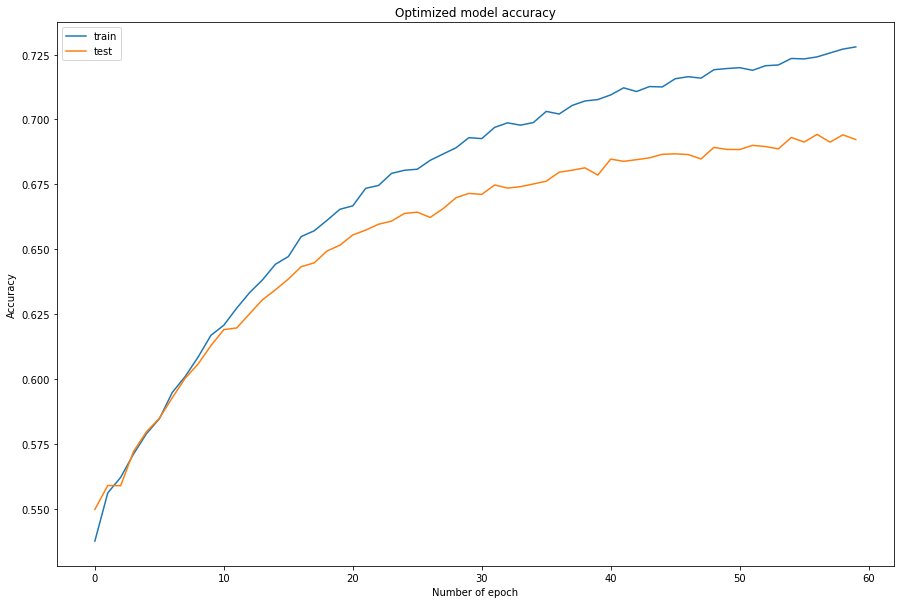

In [23]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(history['optimized_model'].history['accuracy'])
plt.plot(history['optimized_model'].history['val_accuracy'])
plt.title('Optimized model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()